In [1]:
# on-policy first-visit MC prediction, on-policy every-visit MC prediction, TD, n-step TD, TD(λ)

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gymnasium as gym
import gym_walk, gym_aima
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count
import itertools
import tabulate

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.rcdefaults()
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P), dtype=np.float64)
    while True:
        V = np.zeros(len(P), dtype=np.float64)
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None,
                                action_symbols=('<', '>'), 
                                prec=3, title='Action-value function:'):
    
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123)
    results = []
    for _ in range(n_episodes):
        (state, info), done, steps = env.reset(), False, 0
        while not done and steps < max_steps:
            state, reward, done, truncated, info = env.step(pi(state))
            steps += 1
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100

In [9]:
def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123)
    results = []
    for _ in range(n_episodes):
        (state, info), done, steps = env.reset(), False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, truncated, info = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)

In [10]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [11]:
data = np.array([1, 2, 3, 4, 5, 6, 6])
data[np.argwhere(data > 4)]

array([[5],
       [6],
       [6]])

In [12]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(
        valid_values, 
        min(len(valid_values), limit_items), 
        replace=False
    )
    
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(
            subset, 
            [p.get_label() for p in subset], 
            loc='center right', 
            bbox_to_anchor=(1.25, 0.5)
        )
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [13]:
def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]
    
    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1]*1.02), V_true[init_state]+.01, label)

    plt.scatter(x, y, 
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()

[ 10.          12.91549665  16.68100537  21.5443469   27.82559402
  35.93813664  46.41588834  59.94842503  77.42636827 100.        ]
[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


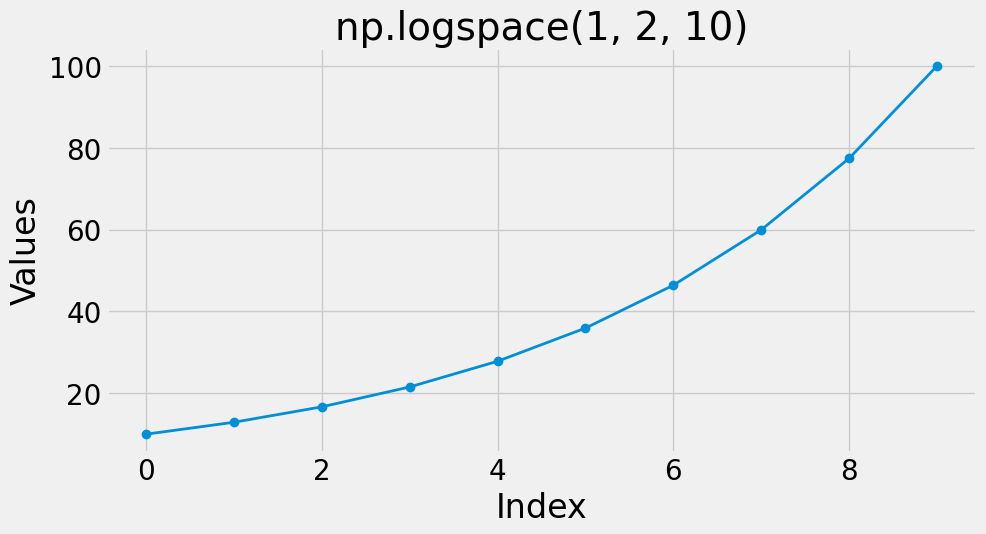

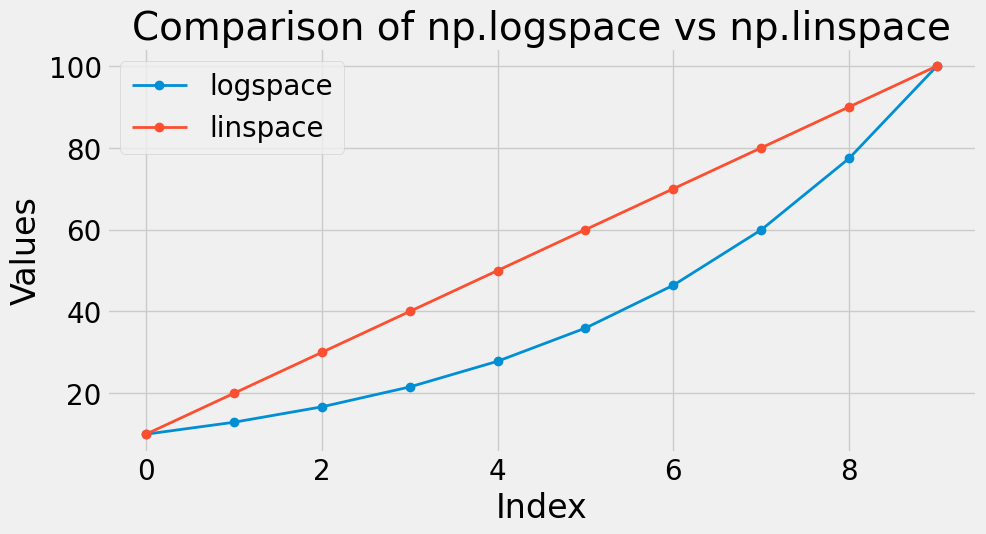

In [14]:
# Example of np.logspace
# np.logspace generates numbers evenly spaced on a log scale
# Parameters:
# - start: base**start is the starting value
# - stop: base**stop is the final value
# - num: number of points to generate
# - base: the base of the log space (default is 10)

import numpy as np
import matplotlib.pyplot as plt

# Create an array of 10 numbers evenly spaced on a log scale from 10^1 to 10^2
log_array = np.logspace(1, 2, 10)
print(log_array)
# Compare with linear space
lin_array = np.linspace(10, 100, 10)
print(lin_array)

# Visualize the logspace
plt.figure(figsize=(10, 5))
plt.plot(log_array, 'o-', linewidth=2)
plt.title('np.logspace(1, 2, 10)')
plt.ylabel('Values')
plt.xlabel('Index')
plt.grid(True)
plt.show()

# Compare with linear space
plt.figure(figsize=(10, 5))
plt.plot(log_array, 'o-', label='logspace', linewidth=2)
plt.plot(lin_array, 'o-', label='linspace', linewidth=2)
plt.title('Comparison of np.logspace vs np.linspace')
plt.ylabel('Values')
plt.xlabel('Index')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
data
np.pad(data, (0, 5), 'edge')


array([1, 2, 3, 4, 5, 6, 6, 6, 6, 6, 6, 6])

In [16]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

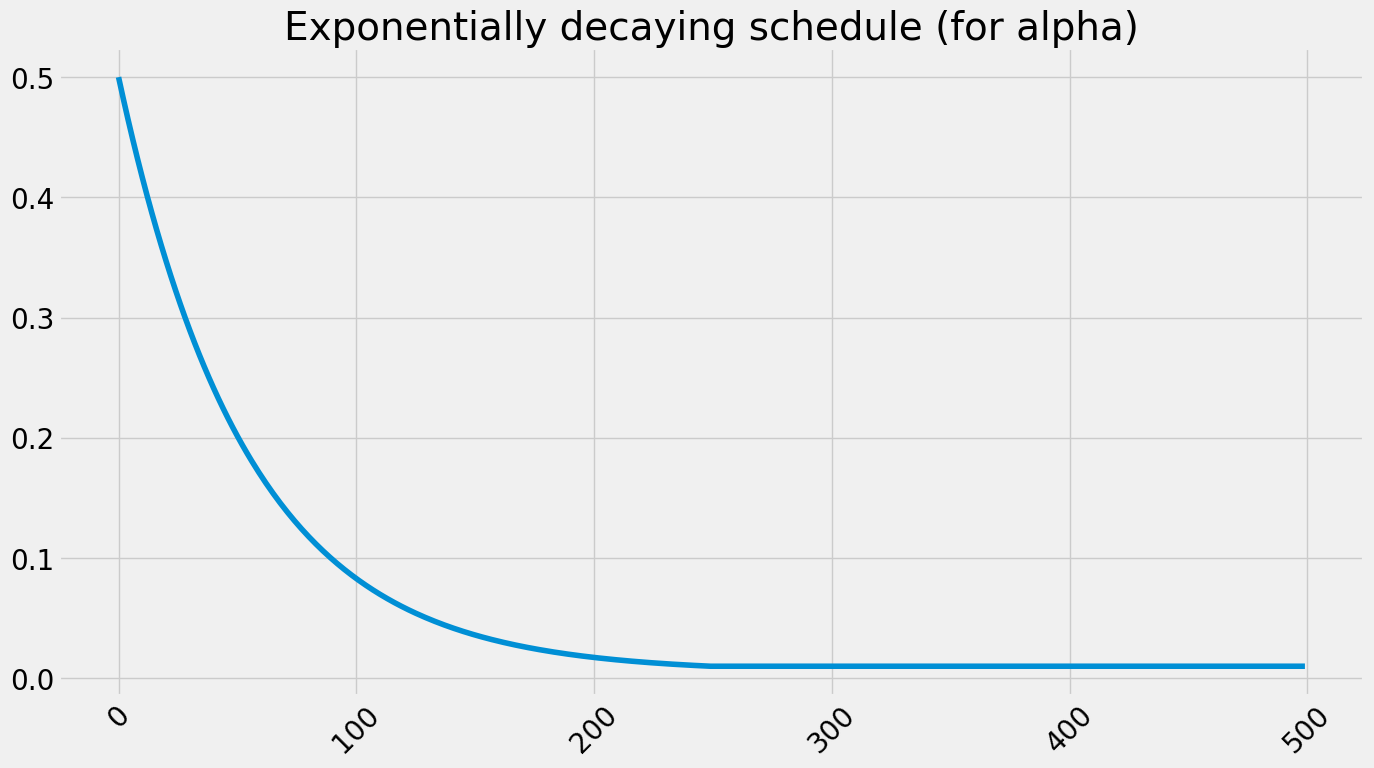

In [17]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

# Random walk/Deterministic walk with uniformly random policy

In [18]:
from gymnasium.envs.registration import register

# classics
register(
    # five non-terminal states and two terminal
    # same as below
    id='RandomWalk-v0',
    entry_point='gym_walk.envs:WalkEnv',
    # left-most and right-most states are terminal
    kwargs={'n_states': 5, 'p_stay': 0.0, 'p_backward': 0.5},
    max_episode_steps=100,
    reward_threshold=1.0,
    nondeterministic=True,
)

In [19]:
env = gym.make('RandomWalk-v0')
init_state = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.unwrapped.P

LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.083 | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 | 06  0.417 |

Policy:
| 00      < | 01      < | 02      < | 03      < | 04      < | 05      < | 06      < |
Reaches goal 54.00%. Obtains an average return of 0.4500.


# First-visit Monte-Carlo prediction

In [20]:
def generate_trajectory(pi, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state, info = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, truncated, info = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [21]:
def mc_prediction(pi, 
                    env, 
                    gamma=1.0,
                    init_alpha=0.5,
                    min_alpha=0.01,
                    alpha_decay_ratio=0.5,
                    n_episodes=500, 
                    max_steps=200,
                    first_visit=True):
    nS = env.observation_space.n
    discounts = np.logspace(0, 
                            max_steps, 
                            num=max_steps, 
                            base=gamma, 
                            endpoint=False)
    alphas = decay_schedule(init_alpha, 
                            min_alpha, 
                            alpha_decay_ratio, 
                            n_episodes)
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(pi, 
                                            env, 
                                            max_steps)
        visited = np.zeros(nS, dtype=np.bool)
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if visited[state] and first_visit:
                continue
            visited[state] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            targets[state].append(G)
            mc_error = G - V[state]
            V[state] = V[state] + alphas[e] * mc_error
        V_track[e] = V
    return V.copy(), V_track, targets

In [22]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'TimeLimit' object has no attribute 'seed'

In [ ]:
print_state_value_function(V_fvmc, P, n_cols=7)
print()
print_state_value_function(V_fvmc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

In [ ]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

In [ ]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

# Every-visit Monte-Carlo prediction

In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

In [ ]:
print_state_value_function(V_evmc, P, n_cols=7)
print()
print_state_value_function(V_evmc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

In [ ]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

# Temporal-Difference Prediction (TD)

In [26]:
def td(pi, 
       env, 
       gamma=1.0,
       init_alpha=0.5,
       min_alpha=0.01,
       alpha_decay_ratio=0.5,
       n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            targets[state].append(td_target)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            state = next_state
        V_track[e] = V
    return V, V_track, targets

In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [ ]:
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

In [ ]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

In [ ]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

# Comparing MC and TD

In [ ]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:20], None, log=False)

In [ ]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:20], None, log=False)

In [ ]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

In [ ]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

In [ ]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

In [ ]:
plot_targets(targets_td, init_state, title='TD target sequence')

# n-step TD

In [37]:
def ntd(pi, 
        env, 
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        n_step=3,
        n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    discounts = np.logspace(0, n_step+1, num=n_step+1, base=gamma, endpoint=False)
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done, path = env.reset(), False, []
        while not done or path is not None:
            path = path[1:]
            while not done and len(path) < n_step:
                action = pi(state)
                next_state, reward, done, _ = env.step(action)
                experience = (state, reward, next_state, done)
                path.append(experience)
                state = next_state
                if done:
                    break

            n = len(path)
            est_state = path[0][0]
            rewards = np.array(path)[:,1]
            partial_return = discounts[:n] * rewards
            bs_val = discounts[-1] * V[next_state] * (not done)
            ntd_target = np.sum(np.append(partial_return, bs_val))
            ntd_error = ntd_target - V[est_state]
            V[est_state] = V[est_state] + alphas[e] * ntd_error
            if len(path) == 1 and path[0][3]:
                path = None

        V_track[e] = V
    return V, V_track

In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [ ]:
print_state_value_function(V_ntd, P, n_cols=7)
print()
print_state_value_function(V_ntd - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

In [ ]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

# TD(λ)

In [43]:
def td_lambda(pi, 
              env, 
              gamma=1.0,
              init_alpha=0.5,
              min_alpha=0.01,
              alpha_decay_ratio=0.5,
              lambda_=0.3,
              n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    E = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [ ]:
print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

In [ ]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)

# Russell & Norvig Gridworld environment and sample policy

In [ ]:
env = gym.make('RussellNorvigGridworld-v0')
init_state = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 1000
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

# Russell & Norvig Gridworld policy estimation (policy to state-value function)

In [ ]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

In [ ]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

In [ ]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [ ]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [ ]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [ ]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

# Russell & Norvig Gridworld state-value function estimation

In [ ]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

In [ ]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

# Russell & Norvig Gridworld state-value function estimation (x axis in log scale)

In [ ]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

In [ ]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

# Close ups

In [ ]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:50], None, log=False)

In [ ]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:50], None, log=False)

In [ ]:
plot_value_function('TD estimates through time (close up)', V_track_td[:50], None, log=False)

In [ ]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:50], None, log=False)

In [ ]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:50], None, log=False)

# MC vs. TD

In [ ]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

In [ ]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

In [ ]:
plot_targets(targets_td, init_state, title='TD target sequence')

# FrozenLake environment and sample policy

In [ ]:
env = gym.make('FrozenLake-v0')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 2500
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:LEFT,   1:UP,     2:UP,    3:UP,
    4:LEFT,   5:LEFT,   6:LEFT,  7:LEFT,
    8:UP,     9:DOWN,  10:LEFT, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

# FrozenLake policy estimation (policy to state-value function)

In [ ]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

In [ ]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

In [ ]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [ ]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [ ]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [ ]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

# FrozenLake state-value function estimation

In [ ]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

In [ ]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

# FrozenLake state-value function estimation (x axis in log scale)

In [ ]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

In [ ]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

# Close ups

In [ ]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:100], None, log=False)

In [ ]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:100], None, log=False)

In [ ]:
plot_value_function('TD estimates through time (close up)', V_track_td[:100], None, log=False)

In [ ]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:100], None, log=False)

In [ ]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:100], None, log=False)

# MC vs. TD

In [ ]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

In [ ]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

In [ ]:
plot_targets(targets_td, init_state, title='TD target sequence')